Embeddings: {'embedding': [-5.495417594909668, 4.505753517150879, 1.522052526473999, -1.1471350193023682, 1.7370119094848633, -0.9299463629722595, 1.0211681127548218, 4.5342559814453125, -1.5149223804473877, 4.554565906524658, -4.422722816467285, -0.09161417931318283, -1.5994741916656494, -1.219341516494751, 2.020937442779541, -0.06823760271072388, 1.8086012601852417, 0.4236472249031067, 1.367499828338623, 4.983837604522705, -4.103639602661133, 2.142219066619873, 1.184741497039795, 0.3894806504249573, -0.2046753615140915, -0.2956088185310364, -5.276050567626953, 1.7648838758468628, -0.5611724257469177, 0.6236180663108826, 1.886815071105957, 3.033280611038208, 1.169715166091919, -0.6271041035652161, -0.9542452096939087, -2.155688524246216, 0.5615313649177551, -0.5464206337928772, 1.8076512813568115, -2.208606719970703, 2.726923704147339, 0.10941031575202942, -0.47216424345970154, 0.14909124374389648, 0.15486052632331848, 1.5928009748458862, 1.755943775177002, 0.11001555621623993, 1.0511

In [1]:
! pip install datasets
# ! pip install pycaret


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 7.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 12.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 7.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 8.7 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.10.0
    Uninstalling fsspec-2024.10.0:
      Successfully uninstalled fsspec-2024.10.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.9.0 which is incompatible.


In [2]:
from datasets import load_dataset
import pandas as pd
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity



ds = load_dataset("PiC/phrase_similarity")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/5.47k [00:00<?, ?B/s]

phrase_similarity.py:   0%|          | 0.00/4.75k [00:00<?, ?B/s]

0000.parquet:   0%|          | 0.00/1.42M [00:00<?, ?B/s]

PS-hard/validation/0000.parquet:   0%|          | 0.00/202k [00:00<?, ?B/s]

PS-hard/test/0000.parquet:   0%|          | 0.00/403k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/7004 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/1000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/2000 [00:00<?, ? examples/s]

In [3]:
ds

DatasetDict({
    train: Dataset({
        features: ['phrase1', 'phrase2', 'sentence1', 'sentence2', 'label', 'idx'],
        num_rows: 7004
    })
    validation: Dataset({
        features: ['phrase1', 'phrase2', 'sentence1', 'sentence2', 'label', 'idx'],
        num_rows: 1000
    })
    test: Dataset({
        features: ['phrase1', 'phrase2', 'sentence1', 'sentence2', 'label', 'idx'],
        num_rows: 2000
    })
})

In [4]:
import requests
import numpy as np
from concurrent.futures import ThreadPoolExecutor

def get_embeddings(prompt, model="llama3.2:1b", url="http://35.208.33.92:5000/api/embeddings"):
    data = {
        "model": model,
        "prompt": prompt
    }

    try:
        # Make the POST request
        response = requests.post(url, json=data)

        # Raise an exception if the request was unsuccessful
        response.raise_for_status()

        # Return the JSON response (assumed to contain embeddings)
        emb = response.json()
        return emb['embedding']

    except requests.exceptions.RequestException as e:
        print(f"Error calling Ollama API: {e}")
        return None

# Example usage
prompt = "Llamas are members of the camelid family"
embeddings = get_embeddings(prompt)

def add_embedding_columns(row):
    # Get embeddings for phrase1 and phrase2
    row["embedding_phrase1"] = get_embeddings(row["phrase1"])
    row["embedding_phrase2"] = get_embeddings(row["phrase2"])
    return row




In [5]:
ds = ds.map(add_embedding_columns)


Map:   0%|          | 0/7004 [00:00<?, ? examples/s]

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

In [6]:
ds

DatasetDict({
    train: Dataset({
        features: ['phrase1', 'phrase2', 'sentence1', 'sentence2', 'label', 'idx', 'embedding_phrase1', 'embedding_phrase2'],
        num_rows: 7004
    })
    validation: Dataset({
        features: ['phrase1', 'phrase2', 'sentence1', 'sentence2', 'label', 'idx', 'embedding_phrase1', 'embedding_phrase2'],
        num_rows: 1000
    })
    test: Dataset({
        features: ['phrase1', 'phrase2', 'sentence1', 'sentence2', 'label', 'idx', 'embedding_phrase1', 'embedding_phrase2'],
        num_rows: 2000
    })
})

In [7]:
# # Apply mapping with updated function
# # Calculate meanvec for each split in the dataset
# for split in ['train', 'validation', 'test']:
#     ds[split] = ds[split].map(
#         lambda x: {
#             'cosine': ((np.array(x['embedding_phrase1']) + np.array(x['embedding_phrase2'])) / 2.0).tolist()
#         }
#     )

In [8]:
cosine_similarity(np.array(ds["train"]["embedding_phrase1"][0]).reshape(1,-1),np.array(ds["train"]["embedding_phrase2"][0]).reshape(1,-1))[0][0]

0.7062106331130273

In [9]:
for split in ['train', 'validation', 'test']:
    ds[split] = ds[split].map(
        lambda x: {
            'cosine': cosine_similarity(np.array(x['embedding_phrase1']).reshape(1,-1),np.array(x['embedding_phrase2']).reshape(1,-1))[0][0]
        }
    )

Map:   0%|          | 0/7004 [00:00<?, ? examples/s]

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

In [10]:
ds

DatasetDict({
    train: Dataset({
        features: ['phrase1', 'phrase2', 'sentence1', 'sentence2', 'label', 'idx', 'embedding_phrase1', 'embedding_phrase2', 'cosine'],
        num_rows: 7004
    })
    validation: Dataset({
        features: ['phrase1', 'phrase2', 'sentence1', 'sentence2', 'label', 'idx', 'embedding_phrase1', 'embedding_phrase2', 'cosine'],
        num_rows: 1000
    })
    test: Dataset({
        features: ['phrase1', 'phrase2', 'sentence1', 'sentence2', 'label', 'idx', 'embedding_phrase1', 'embedding_phrase2', 'cosine'],
        num_rows: 2000
    })
})

In [11]:
cosine_similarities = ds["train"]["cosine"]
labels = ds["train"]["label"]

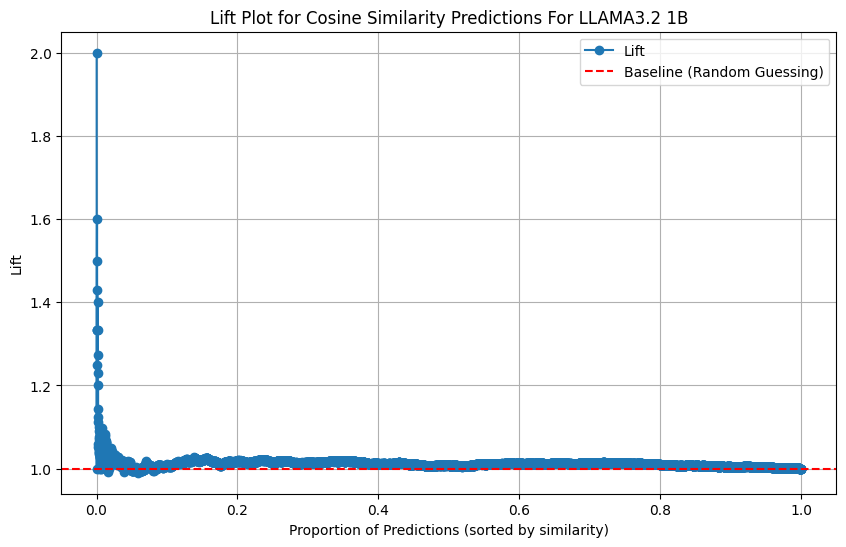

In [26]:
import numpy as np
import matplotlib.pyplot as plt

# Example data
# cosine_similarities = [...]  # List of cosine similarity scores between 0 and 1
# labels = [...]  # List of corresponding labels (0 or 1)

# Convert cosine similarities to binary predictions (>= 0.5 as 1, < 0.5 as 0)
predictions = [1 if score >= 0.6 else 0 for score in cosine_similarities]

# Sort by predicted similarity scores in descending order
sorted_indices = np.argsort(-np.array(cosine_similarities))
sorted_labels = np.array(labels)[sorted_indices]
sorted_predictions = np.array(predictions)[sorted_indices]

# Calculate cumulative true positives and total positives
cumulative_true_positives = np.cumsum(sorted_labels)
total_positives = sum(labels)

# Calculate lift at each percentile of predictions
lift = cumulative_true_positives / (np.arange(1, len(labels) + 1) * total_positives / len(labels))

# Plot the lift curve
plt.figure(figsize=(10, 6))
plt.plot(np.arange(1, len(labels) + 1) / len(labels), lift, marker='o', label="Lift")
plt.axhline(y=1, color='r', linestyle='--', label="Baseline (Random Guessing)")

plt.title("Lift Plot for Cosine Similarity Predictions For LLAMA3.2 1B")
plt.xlabel("Proportion of Predictions (sorted by similarity)")
plt.ylabel("Lift")
plt.legend()
plt.grid()
plt.show()


In [23]:
from sklearn.metrics import accuracy_score
accuracy_score(predictions,labels)

0.5047115933752142

In [24]:
predictions

[0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 1,
 0,
 1,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 1,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 1,
 1,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 1,
 1,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,


In [ ]:
# import ClassificationExperiment and init the class
from pycaret.classification import ClassificationExperiment
exp = ClassificationExperiment()

In [ ]:
exp.setup(train_df, target = 'label', session_id = 123)


,Description,Value
0,Session id,123
1,Target,label
2,Target type,Binary
3,Original data shape,"(7004, 2049)"
4,Transformed data shape,"(7004, 2049)"
5,Transformed train set shape,"(4902, 2049)"
6,Transformed test set shape,"(2102, 2049)"
7,Numeric features,2048
8,Preprocess,True
9,Imputation type,simple


In [ ]:
best = compare_models()


,,
,,
Initiated,. . . . . . . . . . . . . . . . . .,13:21:56
Status,. . . . . . . . . . . . . . . . . .,Fitting 10 Folds
Estimator,. . . . . . . . . . . . . . . . . .,Decision Tree Classifier


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
nb,Naive Bayes,0.4517,0.4377,0.5137,0.4567,0.4832,-0.0967,-0.0975,0.8490
knn,K Neighbors Classifier,0.4055,0.3834,0.4051,0.4044,0.4043,-0.1889,-0.1893,1.7840
lr,Logistic Regression,0.3301,0.3273,0.3272,0.3288,0.3278,-0.3398,-0.3402,16.9280


Processing:   0%|          | 0/65 [00:00<?, ?it/s]

KeyboardInterrupt: 